In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import os
import torch
import torch.utils.tensorboard as tb
import imgaug.augmenters as iaa

### (a.i & a.ii)

In [5]:
data_path = 'CSCE421_Fall2019_ClassMaterial/Homework5_YaleDataset'
X = []
X_resize = []
y1 = []
y2 = []
y3 = []
images = []
for root, dirs, files in os.walk(data_path, topdown=True):
    for file in files:
        path = os.path.join(root,file)
        img = Image.open(path)
        images.append(np.asarray(img))
        X.append(np.asarray(img).flatten())
        X_resize.append(np.asarray(img.resize((30,30))).flatten())
        y1.append(int(file[7:9])-1)
        s = file[file.find('.')+1:]
        idx = s.find('.')
        if idx>=0:
            s0 = s[:idx]
        else:
            s0 = s
            
        if s0 == 'glasses' or (int(file[7:9]) in (8, 13) and s0!='noglasses') or (int(file[7:9])==14 and 'light' in s0):
            y3.append(1)
        else:
            y3.append(0)
            
        if s0 in ('glasses', 'noglasses','normal','gif','leftlight', 'rightlight','centerlight'):
            y2.append(0)
        elif s0 == 'happy':
            y2.append(1)
        elif s0 == 'sad':
            y2.append(2)
        elif s0 == 'sleepy':
            y2.append(3)
        elif s0 == 'surprised':
            y2.append(4)
        elif s0 == 'wink':
            y2.append(5)
        else:
            print('error')
            
images = np.array(images)
y1 = np.array(y1)
y2 = np.array(y2)
y3 = np.array(y3)
X = np.stack(X)
X_resize = np.stack(X_resize)
# X = (X-X.min(axis=0))/(X.max(axis=0)-X.min(axis=0))
X = X/255.0
X_resize = X_resize/255

print(images.shape)
print(X.shape)
print(X_resize.shape)
print(y1.shape)
print(y2.shape)
print(y3.shape)


(165, 243, 320)
(165, 77760)
(165, 900)
(165,)
(165,)
(165,)


### (a.iii) 107 components we need to capture 99% of the energy

In [6]:
from sklearn.decomposition import PCA
for i in range(100, 120):
    
    pca = PCA(i, svd_solver='auto')
    X1 = pca.fit_transform(X)
    print(i, sum(pca.explained_variance_ratio_))
    if sum(pca.explained_variance_ratio_)>=0.99:
        break

100 0.9876467653831247
101 0.9880395024372608
102 0.9884296961256144
103 0.9888244378534886
104 0.9891909912626922
105 0.9895805121854736
106 0.9899351533320456
107 0.9902950166828823


### (a.iii) plot eigenvalues

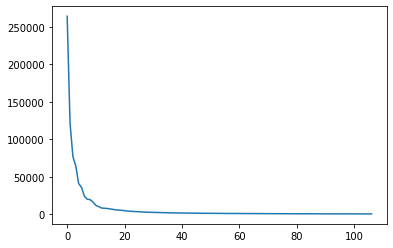

In [7]:
w = pca.singular_values_**2
fig, ax = plt.subplots()
ax.plot(w, '-')

### (a.iv) plot top 10 eigenfaces

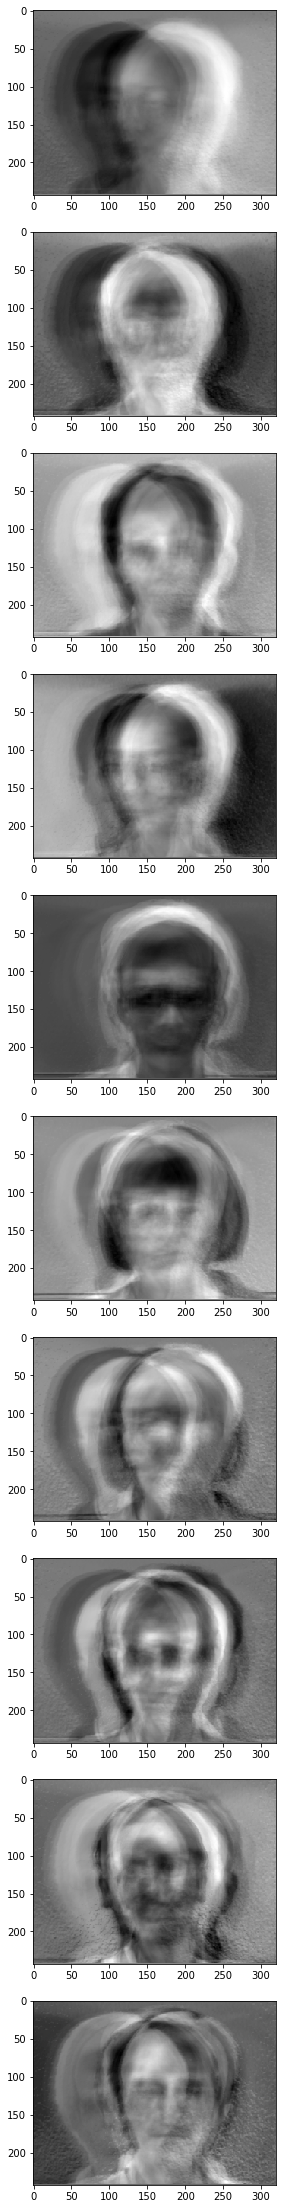

In [8]:
fig, axs = plt.subplots(10, figsize=(10,40))
eigenfaces = pca.components_.reshape((X1.shape[1], 243, 320))
for i in range(10):
    axs[i].imshow(eigenfaces[i]*255, cmap=plt.cm.gray)


### (a.v)

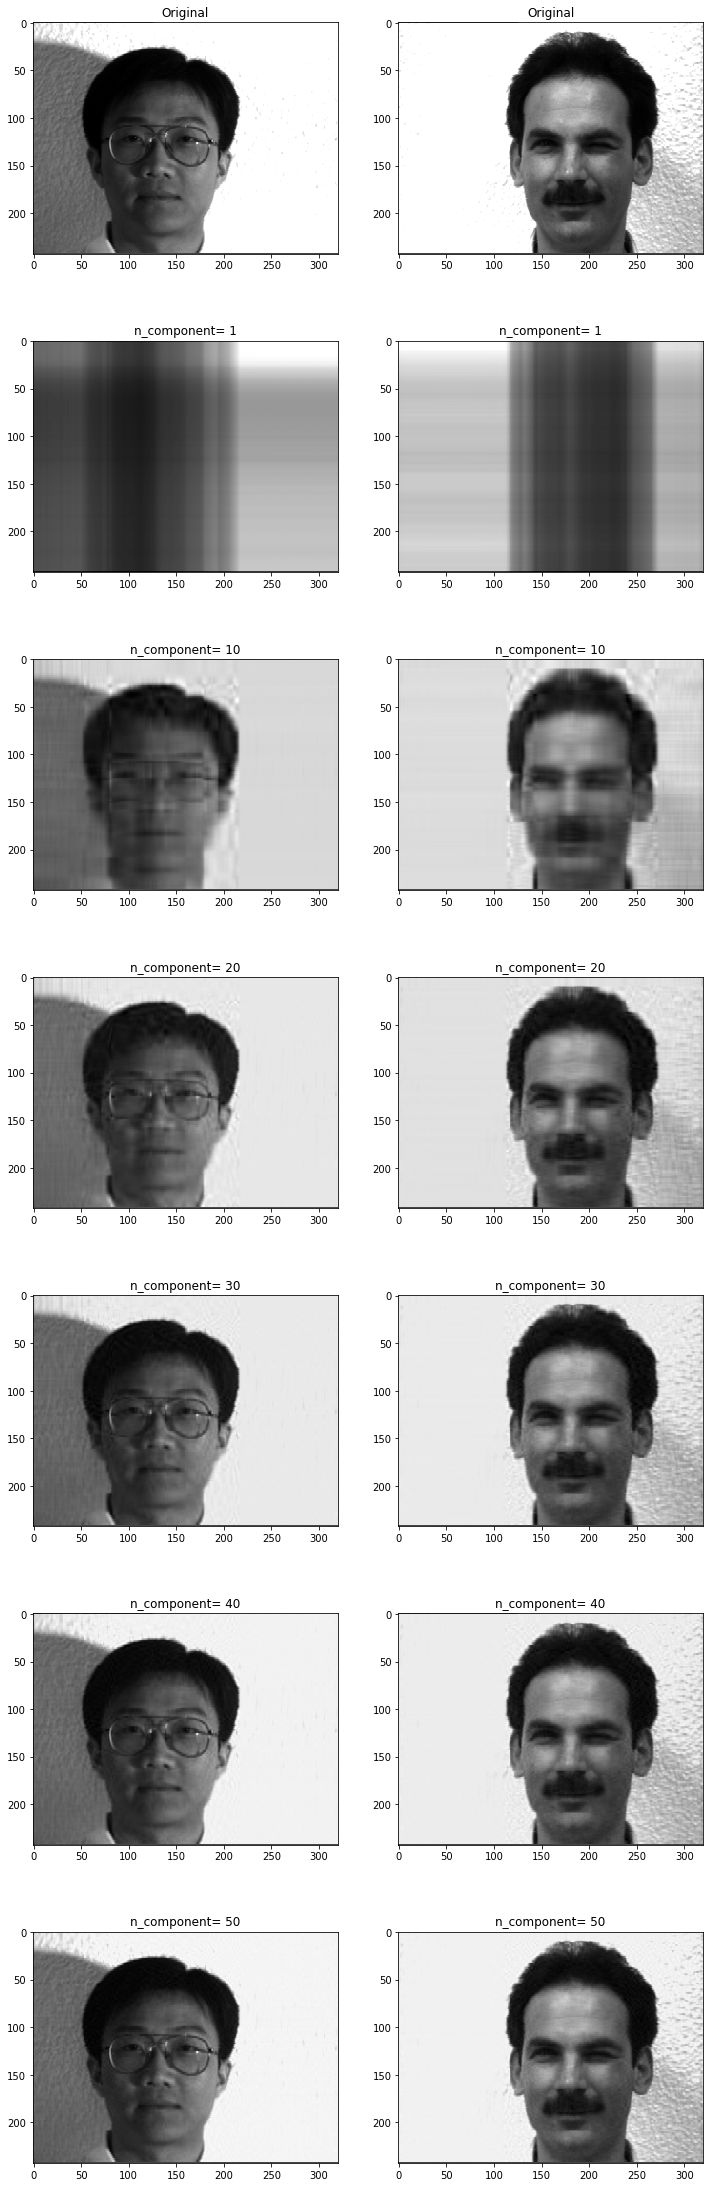

In [9]:
def svg_image(image, k):
    """
    return a list of k images, 
    each is reconstructed via only keeping the k biggest singular values

    """
    u, s, vh = np.linalg.svd(image)
    s1 = np.zeros((image.shape[0], image.shape[1]))
    for i in range(k):
        s1[i][i] = s[i]
    
    return np.dot(np.dot(u, s1), vh)

n_components = (1, 10, 20, 30, 40, 50)
fig, axs = plt.subplots(len(n_components)+1, 2, figsize=(12, 40))
original_image_idx = np.random.randint(0,X.shape[0]-1, 2)
axs[0][0].imshow(images[original_image_idx[0]], cmap=plt.cm.gray)
axs[0][1].imshow(images[original_image_idx[1]], cmap=plt.cm.gray)
axs[0][0].set_title('Original')
axs[0][1].set_title('Original')

for i, n_component in enumerate(n_components):
    image1 = svg_image(images[original_image_idx[0]],n_component)
    image2 = svg_image(images[original_image_idx[1]],n_component)
    axs[i+1][0].imshow(image1, cmap=plt.cm.gray)
    axs[i+1][0].set_title('n_component= ' + str(n_component))
    axs[i+1][1].imshow(image2, cmap=plt.cm.gray)
    axs[i+1][1].set_title('n_component= ' + str(n_component))
    

### (a.vi)

In [10]:
kfold1 = sklearn.model_selection.StratifiedKFold(
    n_splits=5, shuffle=True, random_state=1)

kfold2 = sklearn.model_selection.StratifiedKFold(
    n_splits=5, shuffle=True, random_state=2)

kfold3 = sklearn.model_selection.StratifiedKFold(
    n_splits=5, shuffle=True, random_state=3)

from sklearn.ensemble import RandomForestClassifier
cv_results1 = []
cv_results2 = []
cv_results3 = []

n_components = (10, 15, 20, 25, 30)
for n_component in n_components:
    pca = PCA(n_component)
    X_pca = pca.fit_transform(X)
    rf1 = RandomForestClassifier(100, random_state=1)
    rf2 = RandomForestClassifier(100, random_state=2)
    rf3 = RandomForestClassifier(100, random_state=3)
    cv_results1.append([n_component, sklearn.model_selection.cross_val_score(rf1, X_pca, y1, cv=kfold1).mean()])
    cv_results2.append([n_component, sklearn.model_selection.cross_val_score(rf1, X_pca, y2, cv=kfold2).mean()])
    cv_results3.append([n_component, sklearn.model_selection.cross_val_score(rf1, X_pca, y3, cv=kfold3).mean()])
        

In [11]:
columns = ['n_component', 'average_accuracy']
cv_results1 = pd.DataFrame(cv_results1,columns=columns)
cv_results2 = pd.DataFrame(cv_results2,columns=columns)
cv_results3 = pd.DataFrame(cv_results3,columns=columns)
cv_results = [cv_results1, cv_results2, cv_results3]

In [12]:
cv_results3

,n_component,average_accuracy
0,10,0.835929
1,15,0.842179
2,20,0.848418
3,25,0.860004
4,30,0.842001


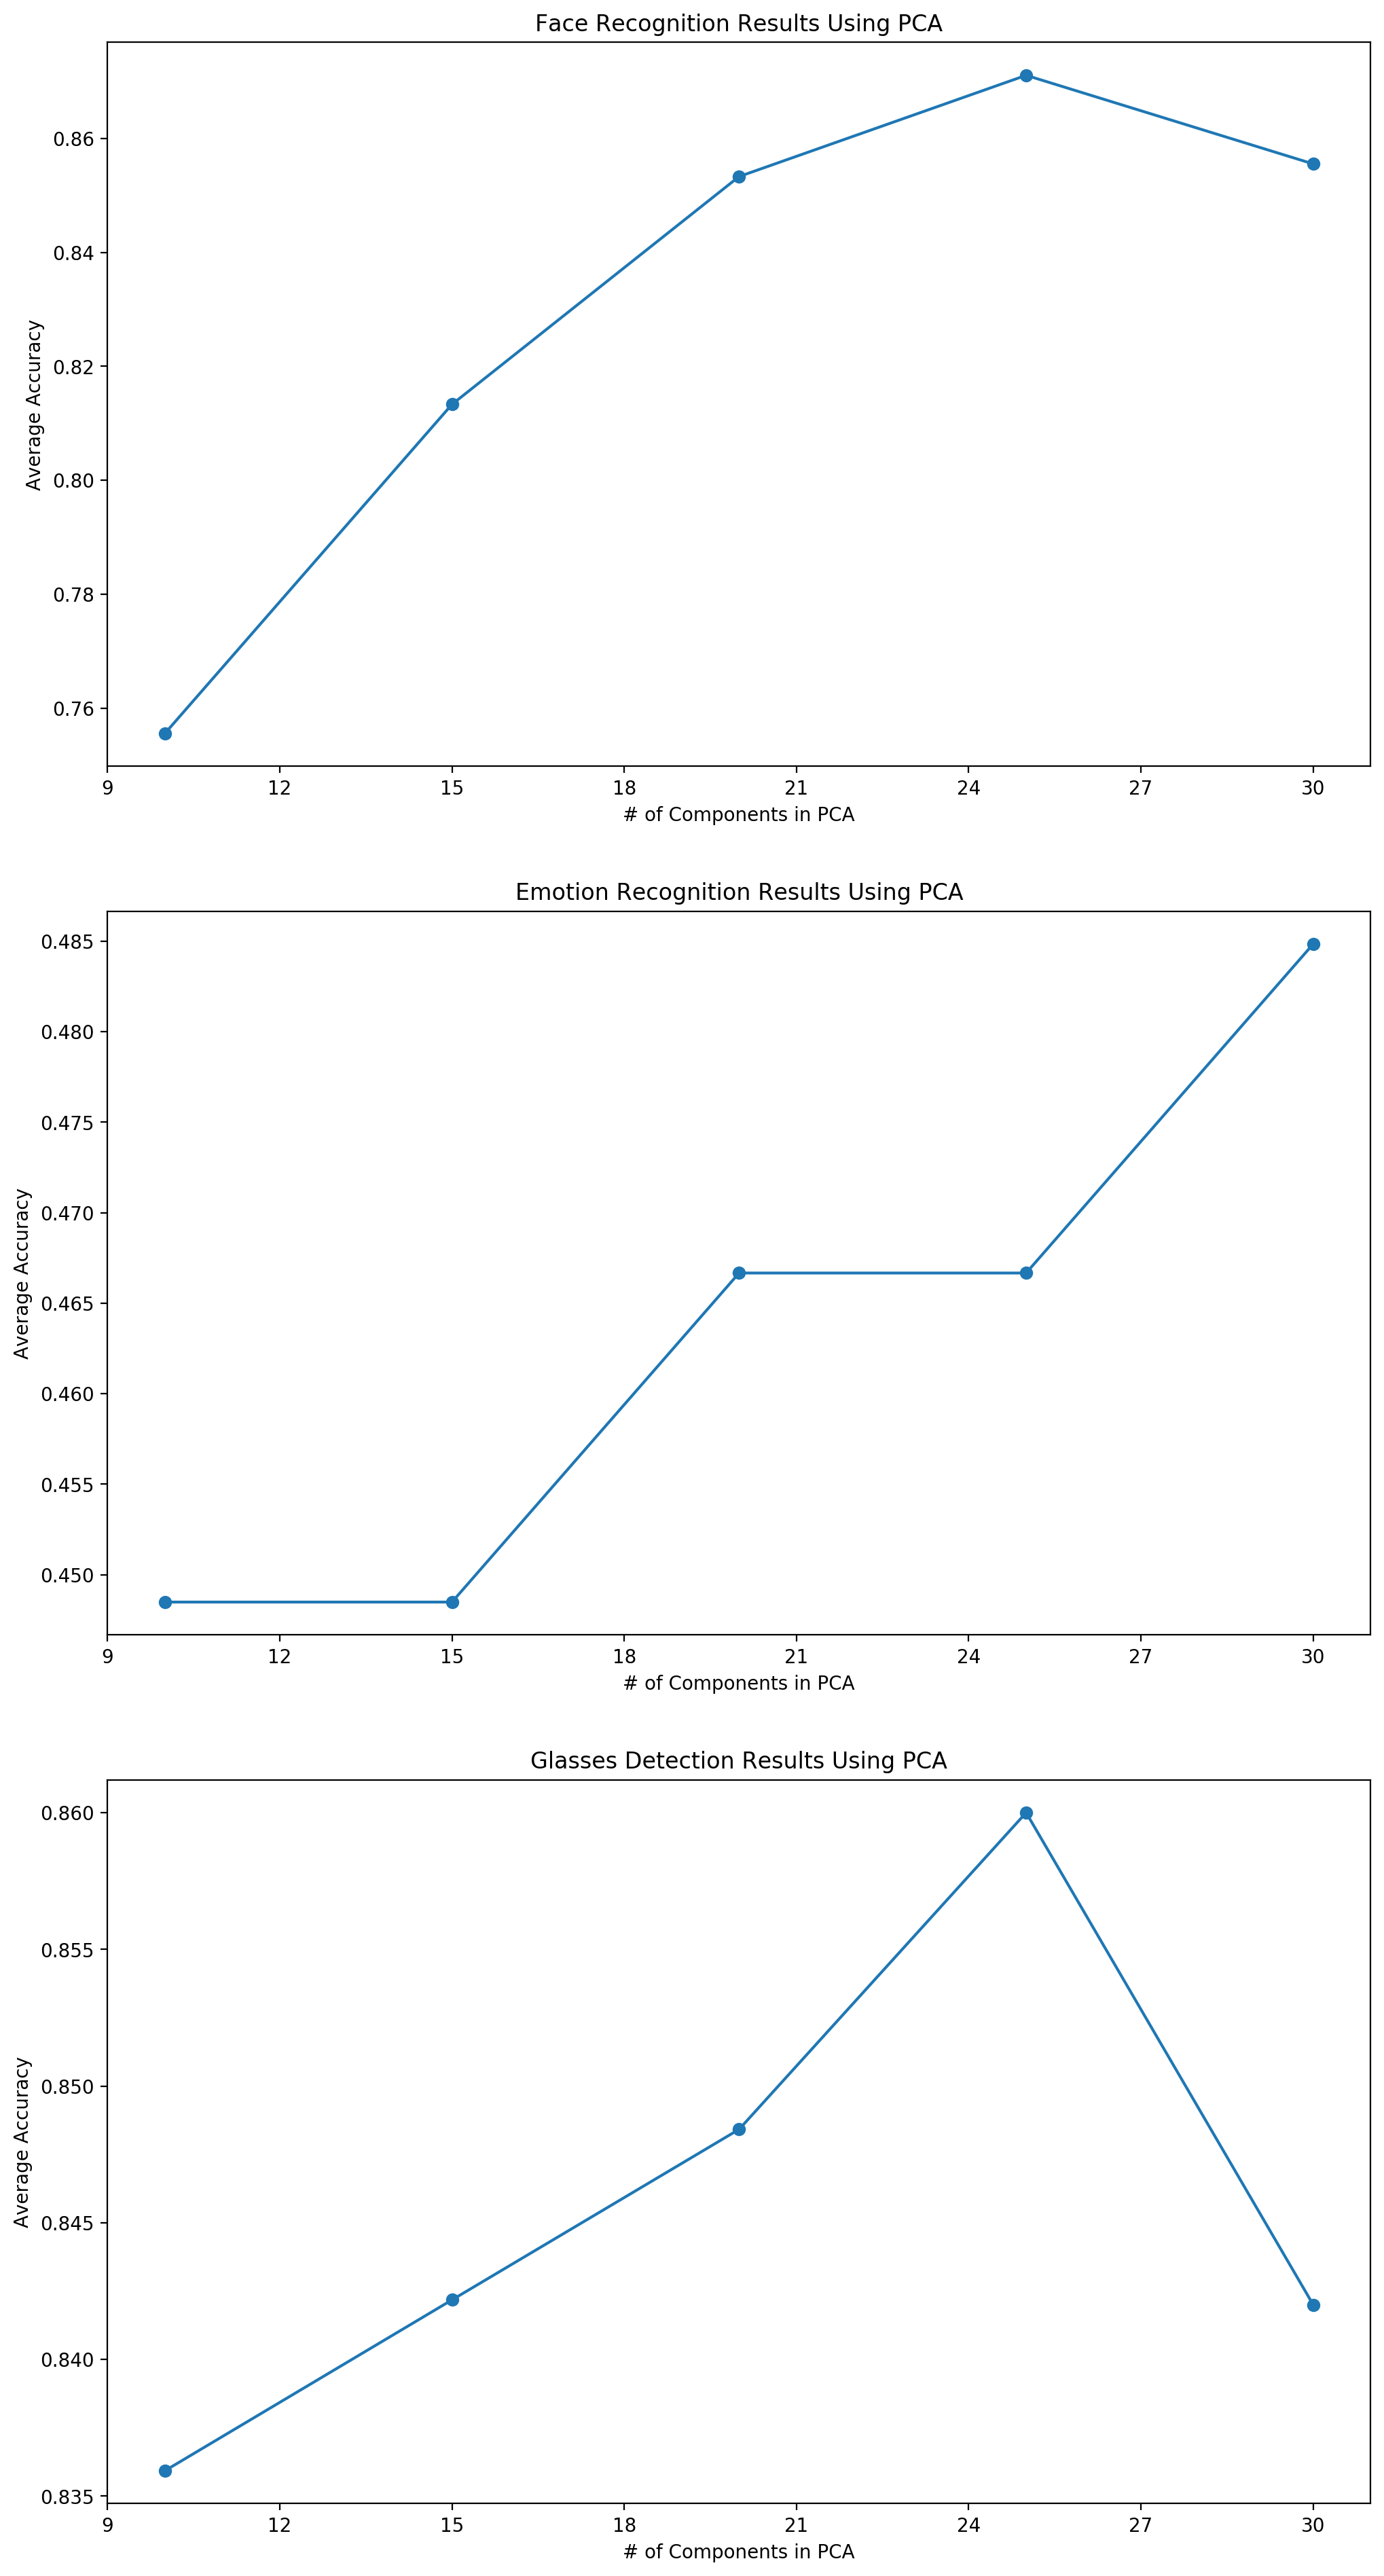

In [13]:
fig, axs = plt.subplots(3, figsize=(12,24), dpi=200)
titles = ['Face Recognition Results Using PCA',
         'Emotion Recognition Results Using PCA',
         'Glasses Detection Results Using PCA']
x_label = '# of Components in PCA'
y_label = "Average Accuracy"
for cv_result, ax, title in zip(cv_results, axs, titles):

    ax.plot(cv_result['n_component'], cv_result['average_accuracy'],'-o')
    ax.set_title(title)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)